In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
!pip install gputil
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [4]:
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)

version : 0.4.1
cuda : True
cudnn : True


In [0]:
EPOCH = 1000
BATCH_SIZE = 200
LR = 0.001
DOWNLOAD_data = True

In [58]:
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_data,
)


Files already downloaded and verified


50000
50000


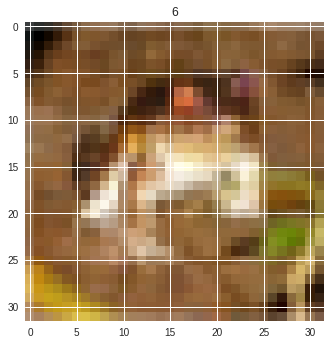

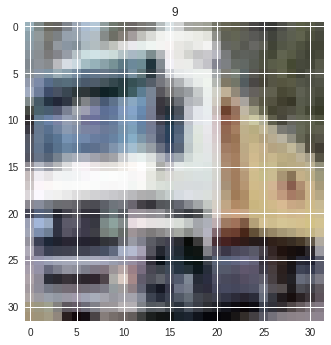

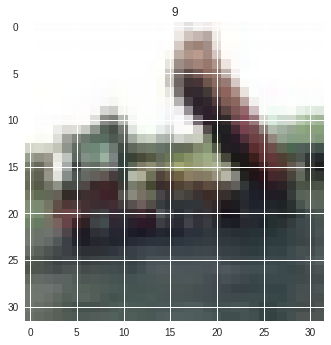

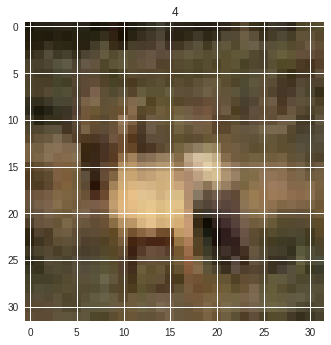

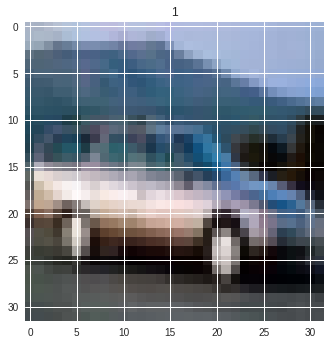

In [59]:
print(len(train_data.train_data))
print(len(train_data.train_labels))
for i in range(5):    
    img = np.asarray(train_data.train_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

In [0]:
test_data = torchvision.datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=torchvision.transforms.ToTensor())

10000


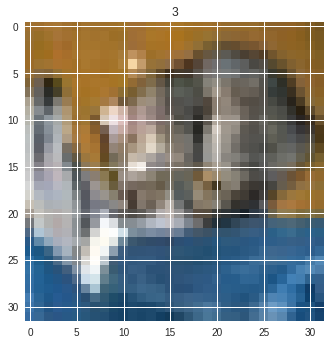

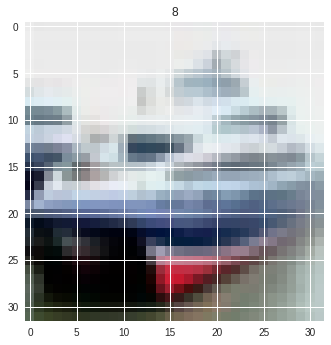

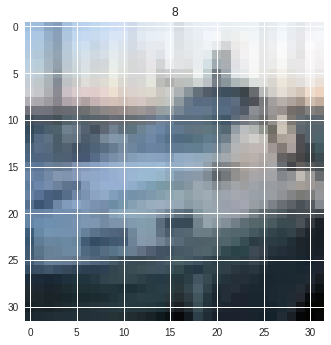

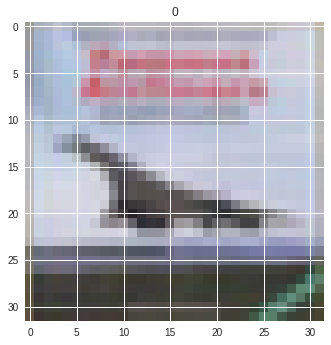

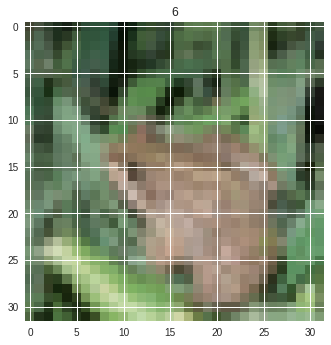

In [61]:
print(len(test_data.test_data))
for i in range(5):    
    img = np.asarray(test_data.test_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % test_data.test_labels[i])
    plt.show()

In [62]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)
print(train_loader)
print(len(train_loader))
print(test_loader)
print(len(test_loader))

250
50


In [63]:
#test_data = torchvision.datasets.CIFAR10(root='./data/', train=False)
#print(type(test_data.test_data))

############
#i dont's know way this type was 'numpy.ndarray', so i convert it myself
#test_data.test_data = torch.unsqueeze(torch.from_numpy(test_data.test_data), dim=3)
print(type(test_data.test_data))
#print(len(test_data.test_data))
############


<class 'numpy.ndarray'>


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),          # output shape (20, 32, 32)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (20, 16, 16)
        )
        self.conv2 = nn.Sequential(         # input shape (20, 16, 16)
            nn.Conv2d(20,40,5,1,2),         # output shape (40, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (40, 8, 8)
        )
        
        self.out1 = nn.Linear(40*8*8, 512)   # fully connected layer
        self.out2 = nn.Linear(512, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        return x    # return x for visualization

In [65]:
cnn = CNN()
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=2560, out_features=512, bias=True)
  (out2): Linear(in_features=512, out_features=128, bias=True)
  (out3): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [0]:
def train(epoch):
    for step, (x, y) in enumerate(train_loader):
        data = Variable(x).cuda()   # batch x
        target = Variable(y).cuda()   # batch y

        output = cnn(data)               # cnn output
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_loader.dataset),100. * step / len(train_loader), loss.data.item()))
    print("Finish")
    
Epoch = np.arange(EPOCH-1)
Loss = np.arange(0)
Accuracy = np.arange(0)

#Loss = np.append(Loss,0.343534543534)
#print(Loss)


def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = cnn(data)
        # sum up batch loss
        los = loss_func(output, target)
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    #print(test_loss)
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    Accuracy = np.append(Accuracy,float(100. * correct / len(test_loader.dataset)))
    
    GPUtil.showUtilization()

In [68]:
for epoch in range(1,EPOCH):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300397
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.717233
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.568896
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.366202
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.377244
Finish

Test set: Average loss: 1.2422, Accuracy: 5498/10000 (54%)

| ID | GPU | MEM |
------------------
|  0 | 16% | 58% |
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.246028
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.250227
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.242473
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.134917
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.159478
Finish

Test set: Average loss: 1.1007, Accuracy: 6092/10000 (60%)

| ID | GPU | MEM |
------------------
|  0 | 16% | 59% |
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.039268
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.150044
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.864525
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.182608
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.948584
Finish

Test se

In [69]:
#torch.save(cnn, 'net.pkl')
#torch.save(cnn.state_dict(), 'net_params.pkl')
print(Epoch)
print(Loss)
print(Accuracy)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

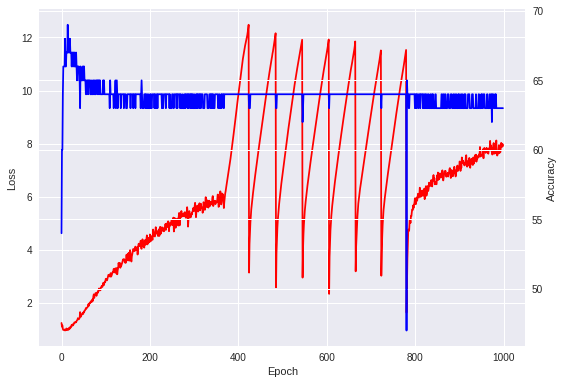

In [70]:
#plot

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(Epoch, Loss, color='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(Epoch, Accuracy,color='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

